In [2]:
# --- CELL 1: SETUP & DEFINITIONS ---
import sys
import os

# 🛠️ QUAN TRỌNG: Thêm folder 'src' vào đường dẫn hệ thống
# Giúp Notebook tìm thấy các file config.py, model_stardist.py...
sys.path.append(os.path.abspath('./src'))

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.draw import polygon

# Import từ project (Sẽ không còn lỗi ModuleNotFoundError)
from config import Config
from model_stardist import StarDist
from dataset_stardist import StarDistDataset
from transform import get_transforms

# --- CÁC HÀM HẬU XỬ LÝ (POST-PROCESSING) ---
# Viết lại thủ công để không phụ thuộc vào thư viện stardist (tránh lỗi version)

def find_peaks(prob_map, prob_thresh=0.5, min_distance=2):
    """Tìm các điểm cực đại cục bộ (tâm tế bào)"""
    H, W = prob_map.shape
    mask = prob_map >= prob_thresh
    if not np.any(mask): return []
    
    size = 2 * min_distance + 1
    footprint = np.ones((size, size), dtype=bool)
    max_filt = maximum_filter(prob_map, footprint=footprint, mode="nearest")
    peaks = (prob_map == max_filt) & mask
    
    ys, xs = np.nonzero(peaks)
    return list(zip(ys.tolist(), xs.tolist()))

def rays_to_polygon_mask(center_y, center_x, rays, H, W):
    """Vẽ đa giác từ các tia khoảng cách"""
    n_rays = rays.shape[0]
    max_radius = max(H, W)
    rays = np.clip(rays, 0.0, float(max_radius))
    
    angles = np.linspace(0, 2 * np.pi, n_rays, endpoint=False)
    ys = center_y + rays * np.sin(angles)
    xs = center_x + rays * np.cos(angles)
    
    ys = np.clip(ys, 0, H - 1)
    xs = np.clip(xs, 0, W - 1)
    
    rr, cc = polygon(ys, xs, (H, W))
    mask = np.zeros((H, W), dtype=bool)
    mask[rr, cc] = True
    return mask

def nms_on_masks(masks, scores, iou_thresh=0.3):
    """Loại bỏ các mask trùng lặp (Non-Maximum Suppression)"""
    if len(masks) == 0: return []
    
    areas = np.array([m.sum() for m in masks], dtype=np.float32)
    order = np.argsort(scores)[::-1]
    keep = []
    used = np.zeros(len(masks), dtype=bool)
    
    for idx in order:
        if used[idx]: continue
        keep.append(idx)
        used[idx] = True
        
        m_i = masks[idx]
        area_i = areas[idx]
        
        for j in order:
            if used[j]: continue
            
            # Tính IoU nhanh
            inter = np.logical_and(m_i, masks[j]).sum()
            if inter == 0: continue
            
            union = area_i + areas[j] - inter
            if inter / union > iou_thresh: 
                used[j] = True
                
    return keep

def predict_single_image(model, image_tensor, device, prob_thresh=0.5, nms_thresh=0.3):
    """Hàm nhận Tensor ảnh -> Trả về Label Mask dự đoán"""
    model.eval()
    with torch.no_grad():
        # Thêm batch dimension nếu chưa có (C, H, W) -> (1, C, H, W)
        if image_tensor.ndim == 3:
            input_tensor = image_tensor.unsqueeze(0)
        else:
            input_tensor = image_tensor
        
        input_tensor = input_tensor.to(device)
        logits, dists = model(input_tensor)
        
        prob_map = torch.sigmoid(logits[0, 0]).cpu().numpy()
        dist_map = dists[0].cpu().numpy() # (n_rays, H, W)

    # Post-process
    H, W = prob_map.shape
    centers = find_peaks(prob_map, prob_thresh=prob_thresh)
    
    masks, scores = [], []
    for (y, x) in centers:
        rays = dist_map[:, y, x]
        if np.all(rays <= 0): continue
        
        m = rays_to_polygon_mask(y, x, rays, H, W)
        if m.sum() > 0:
            masks.append(m)
            scores.append(prob_map[y, x])
            
    keep_idxs = nms_on_masks(masks, scores, iou_thresh=nms_thresh)
    
    # Tạo mask màu (Label)
    label_mask = np.zeros((H, W), dtype=np.int32)
    for i, idx in enumerate(keep_idxs, 1):
        label_mask[masks[idx]] = i
        
    return prob_map, label_mask

print("✅ Cell 1: Setup Complete! Các module đã được load.")

✅ Cell 1: Setup Complete! Các module đã được load.


In [3]:
# 1. Setup
cfg = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# 2. Load Model
model = StarDist(n_channels=3, n_rays=32).to(device)
ckpt_path = 'best_stardist_checkpoint.pth'

try:
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("✅ Đã load Model thành công!")
except FileNotFoundError:
    print("⚠️ Chưa có file checkpoint, dùng model ngẫu nhiên.")

# 3. Load Validation Set (Lấy 1 vài ảnh để test)
# Dùng stage='test' để chỉ resize/crop, không xoay lật lung tung
ds = StarDistDataset(cfg.TRAIN_DIR, transform=get_transforms(cfg, stage='test'), n_rays=32)
print(f"📦 Tổng số ảnh: {len(ds)}")

🚀 Device: cuda
✅ Đã load Model thành công!
📦 Tổng số ảnh: 670


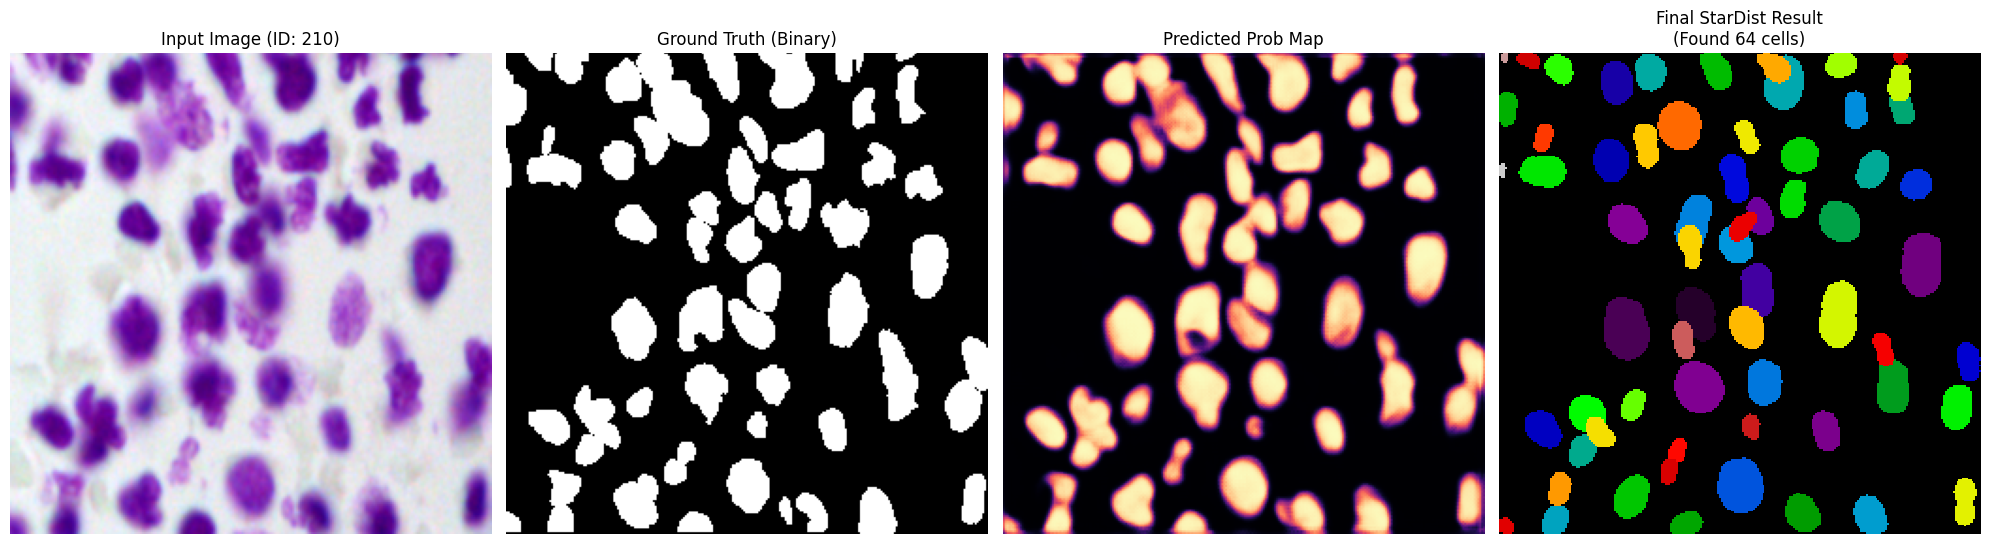

In [7]:
import random

def visualize_result(dataset, model, device):
    # Lấy ngẫu nhiên 1 ảnh
    idx = random.randint(0, len(dataset)-1)
    image, gt_prob, gt_dist = dataset[idx] # gt_prob là mask nhị phân ground truth
    
    # Dự đoán
    pred_prob_map, pred_label_mask = predict_single_image(
        model, image, device, prob_thresh=0.5, nms_thresh=0.3
    )
    
    # Chuẩn bị ảnh input để vẽ (Convert Tensor -> Numpy Image)
    input_img = image.permute(1, 2, 0).cpu().numpy()
    input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min()) # Norm về 0-1 hiển thị
    
    # Chuẩn bị GT Mask
    gt_mask = gt_prob[0].cpu().numpy()

    # --- VẼ HÌNH ---
    plt.figure(figsize=(20, 6))
    
    # 1. Ảnh gốc
    plt.subplot(1, 4, 1)
    plt.imshow(input_img)
    plt.title(f"Input Image (ID: {idx})")
    plt.axis('off')
    
    # 2. Ground Truth (Prob Map)
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth (Binary)")
    plt.axis('off')
    
    # 3. Prediction (Prob Map) - Model nhìn thấy gì?
    plt.subplot(1, 4, 3)
    plt.imshow(pred_prob_map, cmap='magma')
    plt.title("Predicted Prob Map")
    plt.axis('off')
    
    # 4. Final Result (Instance Mask) - Kết quả cuối cùng
    plt.subplot(1, 4, 4)
    # Dùng cmap 'nipy_spectral' để các tế bào có màu khác nhau rõ rệt
    plt.imshow(pred_label_mask, cmap='nipy_spectral', interpolation='nearest')
    plt.title(f"Final StarDist Result\n(Found {pred_label_mask.max()} cells)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- CHẠY VISUALIZE ---
visualize_result(ds, model, device)